In [1]:
import gdown
url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE247806&format=file'
output='./GSE247806_RAW.tar'
gdown.download(url,output)

Downloading...
From: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE247806&format=file
To: /lustre/scratch126/cellgen/team361/am74/Adib/T1D Dr Ardestani/GSE247806/GSE247806_RAW.tar	
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 645M/645M [00:30<00:00, 20.9MB/s]


'./GSE247806_RAW.tar\t'

In [63]:
import gc
gc.collect()

128758

In [ ]:
import scanpy as sc
import pandas as pd
import glob
import os

# Define the base directory where your files are stored
base_directory = './raw_data/'  # Change this to your actual directory

# List of all the file patterns for each condition (Mock, SARS-CoV-2, CVB)
file_patterns = glob.glob(os.path.join(base_directory, 'GSM*.matrix.mtx.gz'))  # Adjust the path if needed

# Empty list to store AnnData objects for each sample
adata_list = []
sample_keys = []  # List to store the GSM numbers for keys

# Loop through each file pattern
for file in file_patterns:
    # Extract the GSM number and condition from the file name
    sample_name = os.path.basename(file).split('.')[0]  # Example: GSM7901012_control-9-mock
    gsm_number = sample_name.split('_')[0]  # Extract GSM number
    condition = sample_name.split('-')[-1]  # Extract condition (mock, SARS-CoV-2, CVB)
    
    print(f"Processing {gsm_number} with condition {condition}")

    # Construct the file paths for the current sample
    barcodes_file = os.path.join(base_directory, f"{sample_name}.barcodes.tsv.gz")  # Ensure the correct file name
    features_file = os.path.join(base_directory, f"{sample_name}.features.tsv.gz")  # Ensure the correct file name
    matrix_file = file  # This is the current matrix file
    
    # Ensure the barcodes and features files exist before proceeding
    if not os.path.exists(barcodes_file):
        print(f"Warning: Barcodes file {barcodes_file} not found.")
        continue
    if not os.path.exists(features_file):
        print(f"Warning: Features file {features_file} not found.")
        continue
    
    # Step 1: Read the matrix data
    adata = sc.read_mtx(matrix_file)
    
    # Step 2: Read the barcodes and features
    adata_bc = pd.read_csv(barcodes_file, header=None)
    adata_features = pd.read_csv(features_file, header=None)
    
    # Step 3: Transpose the data (cells as rows, genes as columns)
    adata = adata.T
    
    # Step 4: Assign cell IDs and gene names
    adata.obs['cell_id'] = adata_bc[0].tolist()  # Assign cell IDs from barcodes
    adata.var['gene_name'] = adata_features[0].tolist()  # Assign gene names from features
    
    # Step 5: Set the gene names as the index in var
    adata.var.index = adata.var['gene_name']
    
    # Step 6: Add sample metadata to `obs`
    adata.obs['status'] = condition  # Condition (Mock, SARS-CoV-2, CVB)
    adata.obs['sample'] = gsm_number  # GSM number as sample ID
    
    # Add the current sample's AnnData object to the list
    adata_list.append(adata)
    sample_keys.append(gsm_number)  # Store GSM number for keys

# Check the number of samples processed
print(f"Total samples processed: {len(adata_list)}")

# Step 7: Concatenate all AnnData objects with unique sample keys
if len(adata_list) > 1:
    # Concatenate all the samples and label by the GSM number
    combined_adata = sc.concat(adata_list, label='sample', keys=sample_keys)
else:
    print("Warning: Only one sample processed. No concatenation performed.")
    combined_adata = adata_list[0]  # Just use the single sample if only one is found

# Step 8: Inspect the combined AnnData object
print(combined_adata)

# Verify that 'sample' column reflects GSM number for each individual cell
print(combined_adata.obs['sample'].value_counts())


Processing GSM7901013 with condition 2
Processing GSM7901021 with condition 2
Processing GSM7901019 with condition mock
Processing GSM7901015 with condition 2


In [65]:
import pandas as pd

sample_to_status = {
    'GSM7901012': 'Mock',
    'GSM7901013': 'SARS-CoV-2',
    'GSM7901014': 'Mock',
    'GSM7901015': 'SARS-CoV-2',
    'GSM7901016': 'CVB',
    'GSM7901017': 'Mock',
    'GSM7901018': 'SARS-CoV-2',
    'GSM7901019': 'Mock',
    'GSM7901020': 'CVB',
    'GSM7901021': 'CVB'
}

# Assuming you already have the AnnData object `adata`
# Check the sample IDs in your adata.obs['sample']
# If 'sample' is the column that contains these IDs, update the status based on the dictionary

# Map the status to the sample IDs in adata.obs
combined_adata.obs['status'] = combined_adata.obs['sample'].map(sample_to_status)

# Check the updated 'status' column
print(combined_adata.obs[['sample', 'status']].head())


       sample      status
0  GSM7901013  SARS-CoV-2
1  GSM7901013  SARS-CoV-2
2  GSM7901013  SARS-CoV-2
3  GSM7901013  SARS-CoV-2
4  GSM7901013  SARS-CoV-2


In [66]:
import numpy as np
np.unique(combined_adata.obs['status'])

array(['CVB', 'Mock', 'SARS-CoV-2'], dtype=object)

In [31]:
bb = combined_adata.var

In [32]:
bb

""
gene_name
ENSG00000243485\tMIR1302-2HG\tGene Expression
ENSG00000237613\tFAM138A\tGene Expression
ENSG00000186092\tOR4F5\tGene Expression
ENSG00000238009\tAL627309.1\tGene Expression
ENSG00000239945\tAL627309.3\tGene Expression
...
GU280_gp08\tCoV2_ORF7b\tGene Expression
GU280_gp09\tCoV2_ORF8\tGene Expression
GU280_gp10\tCoV2_N\tGene Expression


In [33]:
combined_adata.var_names = combined_adata.var_names.str.split('\t').str[1]

In [34]:
combined_adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'CoV2_ORF3a', 'CoV2_E', 'CoV2_M', 'CoV2_ORF6', 'CoV2_ORF7a',
       'CoV2_ORF7b', 'CoV2_ORF8', 'CoV2_N', 'CoV2_ORF10', 'polyprotein'],
      dtype='object', name='gene_name', length=36613)

In [35]:
combined_adata.var

""
gene_name
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
CoV2_ORF7b
CoV2_ORF8
CoV2_N


In [36]:
combined_adata.X.max()

44287.0

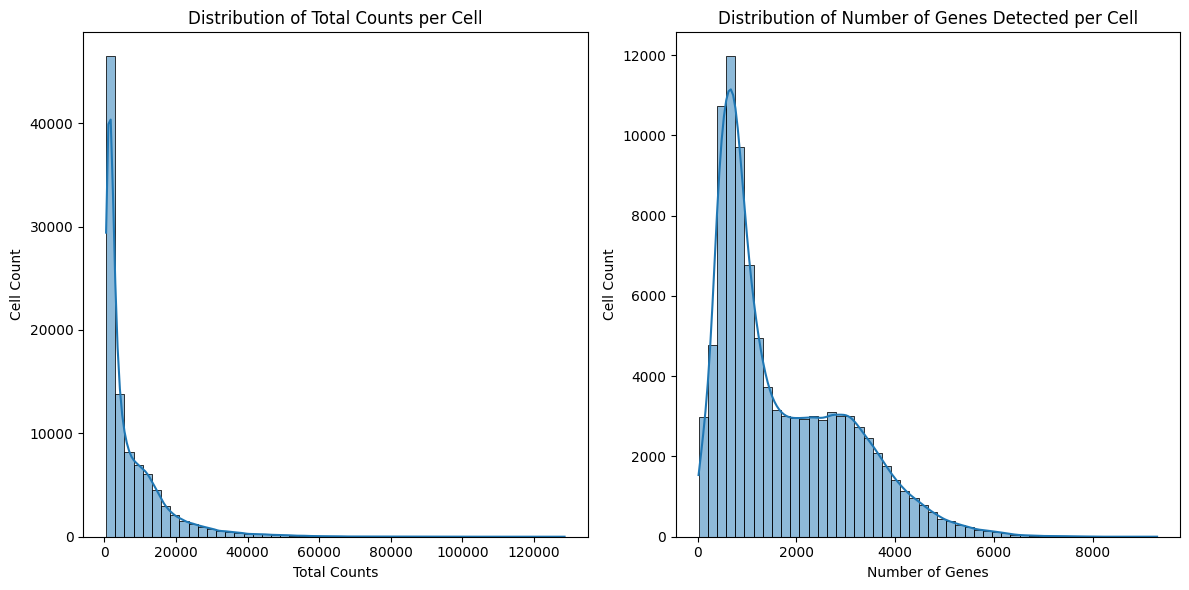

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate the total counts (sum of counts across all genes) and the number of genes detected per cell
combined_adata.obs['n_counts'] = combined_adata.X.sum(axis=1).A1  # Convert sparse matrix to dense and sum counts per cell
combined_adata.obs['n_genes'] = (combined_adata.X > 0).sum(axis=1).A1  # Count the number of non-zero genes per cell

# Step 2: Plot the distribution of total counts and number of genes detected

# Plot total counts (n_counts)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(combined_adata.obs['n_counts'], kde=True, bins=50)
plt.title('Distribution of Total Counts per Cell')
plt.xlabel('Total Counts')
plt.ylabel('Cell Count')

# Plot number of genes detected (n_genes)
plt.subplot(1, 2, 2)
sns.histplot(combined_adata.obs['n_genes'], kde=True, bins=50)
plt.title('Distribution of Number of Genes Detected per Cell')
plt.xlabel('Number of Genes')
plt.ylabel('Cell Count')

plt.tight_layout()
plt.show()


In [38]:
import numpy as np

# Step 1: Calculate mitochondrial gene content
# Assuming mitochondrial genes are prefixed with 'MT-' in the gene names
mito_genes = [gene for gene in combined_adata.var_names if gene.startswith('MT-')]
mito_gene_idx = combined_adata.var.index.isin(mito_genes)

# Step 2: Calculate the proportion of mitochondrial genes per cell
combined_adata.obs['mito_fraction'] = combined_adata.X[:, mito_gene_idx].sum(axis=1).A1 / combined_adata.obs['n_counts']

# Step 3: Apply the filtering criteria
min_genes = 500
max_genes = 6000
min_counts = 1000
max_counts = 60000
max_mito_fraction = 0.15  # 15%

# Filter cells based on criteria
filtered_adata = combined_adata[
    (combined_adata.obs['n_genes'] >= min_genes) & 
    (combined_adata.obs['n_genes'] <= max_genes) &
    (combined_adata.obs['n_counts'] >= min_counts) & 
    (combined_adata.obs['n_counts'] <= max_counts) & 
    (combined_adata.obs['mito_fraction'] <= max_mito_fraction)
]

# Check how many cells were retained after filtering
print(f"Cells retained after filtering: {filtered_adata.n_obs}")

Cells retained after filtering: 70242


In [40]:
sc.pp.normalize_per_cell(filtered_adata,counts_per_cell_after=1e4)
sc.pp.log1p(filtered_adata)

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:580: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation

In [41]:
import celltypist
from celltypist import models

In [42]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /nfs/users/nfs_a/am74/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChallen

In [43]:
model = models.Model.load(model = './Adult_Human_Pancreas.pkl')

In [44]:
model.cell_types

array(['Acinar-mix', 'Activated stellate cells', 'Alpha cells',
       'Beta cells', 'Delta cells', 'Ductal cells', 'Endothelial cells',
       'Gamma cells', 'Idling acinar cells', 'MUC5B+ ductal cells',
       'Macrophages', 'Quiescent stellate cells',
       'Secretory acinar cells', 'Stressed beta cells'], dtype=object)

In [45]:
predictions = celltypist.annotate(filtered_adata, model = 'Adult_Human_Pancreas.pkl', majority_voting = False)

🔬 Input data has 70242 cells and 36613 genes
🔗 Matching reference genes in the model
🧬 6131 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [46]:
data=predictions.predicted_labels
data

,predicted_labels
0,Stressed beta cells
2,Beta cells
4,Beta cells
6,Ductal cells
11,Beta cells
...,...
11810,Alpha cells
11812,Alpha cells
11813,Ductal cells
11814,Alpha cells


In [47]:
filtered_adata = predictions.to_adata()

In [48]:
filtered_adata.obs

,cell_id,status,sample,n_counts,n_genes,mito_fraction,predicted_labels,conf_score
0,AAACCTGAGACTGGGT-1,SARS-CoV-2,GSM7901013,1891.0,1020,0.020095,Stressed beta cells,0.352903
2,AAACCTGAGTAGCGGT-1,SARS-CoV-2,GSM7901013,1139.0,676,0.010536,Beta cells,0.981169
4,AAACCTGCACTTACGA-1,SARS-CoV-2,GSM7901013,1273.0,755,0.138256,Beta cells,0.015690
6,AAACCTGCAGGATTGG-1,SARS-CoV-2,GSM7901013,7263.0,2787,0.128459,Ductal cells,0.997861
11,AAACCTGGTCATCGGC-1,SARS-CoV-2,GSM7901013,1092.0,648,0.043040,Beta cells,0.867767
...,...,...,...,...,...,...,...,...
11810,TTTGTCAGTCGCGAAA-1,Mock,GSM7901017,4759.0,1995,0.045598,Alpha cells,0.999944
11812,TTTGTCAGTGATGCCC-1,Mock,GSM7901017,2536.0,948,0.120268,Alpha cells,0.993266
11813,TTTGTCATCACAATGC-1,Mock,GSM7901017,9018.0,3382,0.094367,Ductal cells,0.791559
11814,TTTGTCATCACAGGCC-1,Mock,GSM7901017,5943.0,1787,0.023557,Alpha cells,0.998575


In [49]:
raw_counts = combined_adata[
    (combined_adata.obs['n_genes'] >= min_genes) & 
    (combined_adata.obs['n_genes'] <= max_genes) &
    (combined_adata.obs['n_counts'] >= min_counts) & 
    (combined_adata.obs['n_counts'] <= max_counts) & 
    (combined_adata.obs['mito_fraction'] <= max_mito_fraction)
]

# Check how many cells were retained after filtering
print(f"Cells retained after filtering: {raw_counts.n_obs}")

Cells retained after filtering: 70242


In [50]:
filtered_adata.layers['counts']=raw_counts.X.copy()

In [51]:
filtered_adata.layers['counts'].max()

40482.0

In [52]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch

In [53]:
sc.pp.highly_variable_genes(
    filtered_adata,
    n_top_genes=4000,
    subset=False,
    layer="counts",
    flavor="seurat_v3")

In [54]:
scvi.model.SCVI.setup_anndata(
    filtered_adata,
    layer="counts",
    categorical_covariate_keys=["sample"])

In [55]:
model = scvi.model.SCVI(filtered_adata)

In [56]:
model.train()

INFO: GPU available: False, used: False
GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Epoch 114/114: 100%|███████████████████████████████████████████████████████████████████████| 114/114 [2:20:23<00:00, 73.50s/it, v_num=1, train_loss_step=5.82e+3, train_loss_epoch=5.77e+3]

INFO: `Trainer.fit` stopped: `max_epochs=114` reached.
`Trainer.fit` stopped: `max_epochs=114` reached.


Epoch 114/114: 100%|███████████████████████████████████████████████████████████████████████| 114/114 [2:20:23<00:00, 73.89s/it, v_num=1, train_loss_step=5.82e+3, train_loss_epoch=5.77e+3]


In [57]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
filtered_adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(70242, 10)

In [58]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(filtered_adata, use_rep='X_scVI')
sc.tl.umap(filtered_adata)

In [59]:
filtered_adata.write_h5ad('./GSE247806.h5ad')

... storing 'cell_id' as categorical
... storing 'status' as categorical


In [1]:
import scanpy as sc

In [2]:
filtered_adata = sc.read('./GSE247806.h5ad')

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(filtered_adata, use_rep='X_scVI')
sc.tl.umap(filtered_adata)

/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
adata = filtered_adata.copy()

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
statuses_of_interest = ['CVB', 'Mock'] 

subset_adata = adata[adata.obs['status'].isin(statuses_of_interest)].copy()


/lustre/scratch126/cellgen/team361/am74/Adib/mambaforge/minicondaa/envs/seurat/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


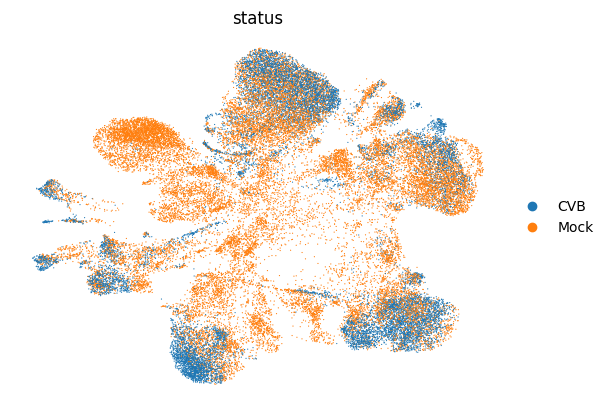

In [41]:
sc.pl.umap(subset_adata, color='status',frameon=False,save='status.png')

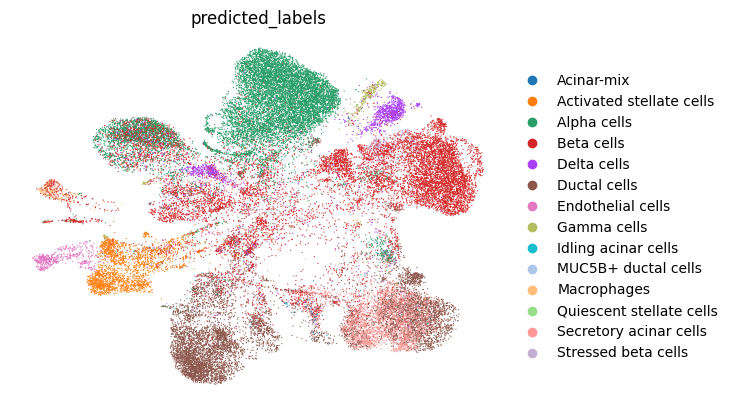

In [42]:
sc.pl.umap(subset_adata, color='predicted_labels',frameon=False,save='predicted_labels.png')

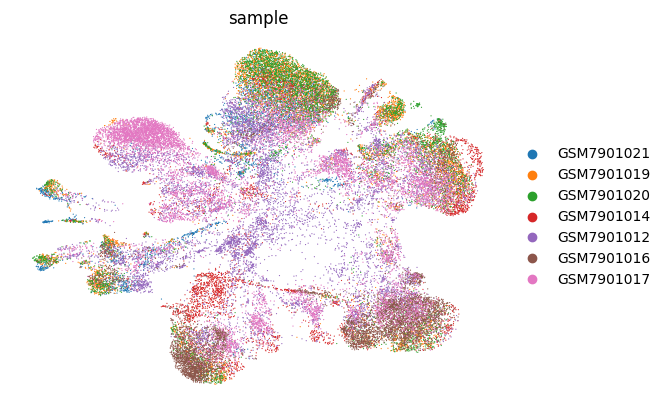

In [43]:
sc.pl.umap(subset_adata, color='sample',frameon=False,save='sample.png')

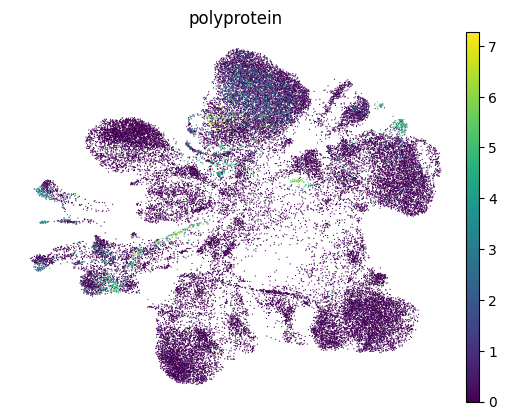

In [44]:
sc.pl.umap(subset_adata, color='polyprotein',frameon=False,save='polyprotein.png')

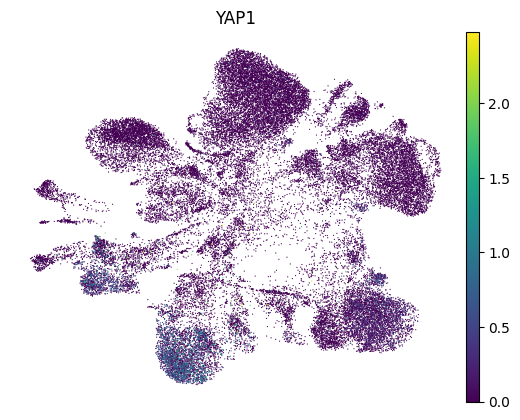

In [45]:
sc.pl.umap(subset_adata, color='YAP1',frameon=False,save='YAP1.png')

/tmp/ipykernel_1441810/3134640699.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = subset_adata.obs.groupby(["status", "predicted_labels"])["polyprotein_expr"].mean().reset_index()
/tmp/ipykernel_1441810/3134640699.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped, x="Cell Type", y="Polyprotein Expression", hue="Status", ci=None)


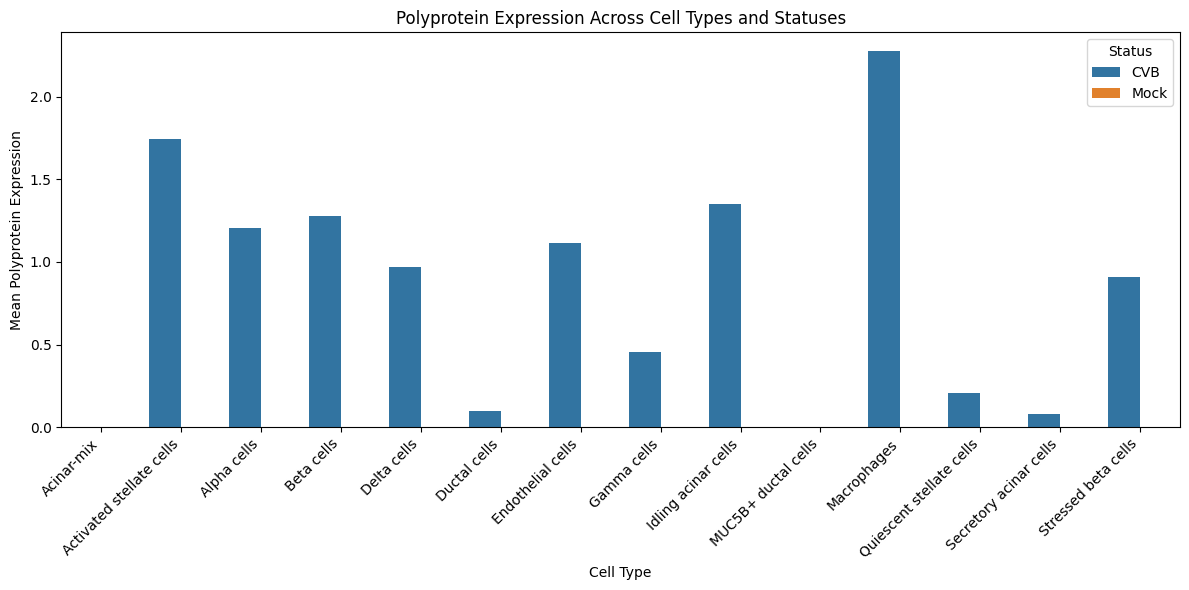

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# Check if 'polyprotein' exists in var_names
if "polyprotein" not in subset_adata.var_names:
    raise ValueError("The gene 'polyprotein' is not present in subset_adata.var_names.")

# Extract the expression data for polyprotein and ensure it's a dense 1D array
polyprotein_expr = subset_adata[:, "polyprotein"].X
polyprotein_expr = polyprotein_expr.toarray().flatten() if issparse(polyprotein_expr) else polyprotein_expr.flatten()

# Ensure length matches the number of observations
if polyprotein_expr.shape[0] != subset_adata.n_obs:
    raise ValueError(f"Mismatch in number of observations: {polyprotein_expr.shape[0]} vs {subset_adata.n_obs}")

# Add it as a new column to obs for easy grouping
subset_adata.obs["polyprotein_expr"] = polyprotein_expr

# Group by status and predicted_labels, and calculate mean polyprotein expression
grouped = subset_adata.obs.groupby(["status", "predicted_labels"])["polyprotein_expr"].mean().reset_index()

# Rename columns for clarity
grouped.columns = ["Status", "Cell Type", "Polyprotein Expression"]

# Plot the barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="Cell Type", y="Polyprotein Expression", hue="Status", ci=None)
plt.xticks(rotation=45, ha="right")
plt.title("Polyprotein Expression Across Cell Types and Statuses")
plt.ylabel("Mean Polyprotein Expression")
plt.xlabel("Cell Type")
plt.legend(title="Status")
plt.tight_layout()

# Save the plot with 600 DPI
plt.savefig("./figures/polyprotein_expression_barplot.png", dpi=600)
plt.show()


In [48]:
# Initialize a new column for infection status
subset_adata.obs["cell_infected_status"] = None

# Process Mock status: label as Mock_celltypename
is_mock = subset_adata.obs["status"] == "Mock"
subset_adata.obs.loc[is_mock, "cell_infected_status"] = (
    "Mock_" + subset_adata.obs.loc[is_mock, "predicted_labels"].astype(str)
)

# Process CVB status
is_cvb = subset_adata.obs["status"] == "CVB"
is_infected = subset_adata.obs["polyprotein_expr"] > 0

# Label Infected_celltypename
subset_adata.obs.loc[is_cvb & is_infected, "cell_infected_status"] = (
    "Infected_" + subset_adata.obs.loc[is_cvb & is_infected, "predicted_labels"].astype(str)
)

# Label NonInfected_celltypename
subset_adata.obs.loc[is_cvb & ~is_infected, "cell_infected_status"] = (
    "NonInfected_" + subset_adata.obs.loc[is_cvb & ~is_infected, "predicted_labels"].astype(str)
)

# Verify results
status_counts = subset_adata.obs["cell_infected_status"].value_counts()
print(status_counts)


cell_infected_status
Mock_Beta cells                         9820
Mock_Alpha cells                        7241
Mock_Ductal cells                       4413
NonInfected_Ductal cells                3408
Infected_Alpha cells                    2581
NonInfected_Alpha cells                 2055
NonInfected_Secretory acinar cells      1720
Mock_Delta cells                        1408
Mock_Secretory acinar cells             1251
Mock_Activated stellate cells           1240
Infected_Beta cells                     1069
NonInfected_Beta cells                  1039
Mock_Stressed beta cells                 550
NonInfected_Activated stellate cells     479
Infected_Activated stellate cells        473
Mock_Endothelial cells                   407
Infected_Ductal cells                    397
Mock_Gamma cells                         305
Infected_Secretory acinar cells          188
Infected_Delta cells                     165
NonInfected_Endothelial cells            140
Infected_Endothelial cells        

In [57]:
import numpy as np

# Check if YAP1 is in var_names
if "YAP1" in subset_adata.var_names:
    # Extract YAP1 expression values
    yap1_expression = subset_adata[:, "YAP1"].X

    # Flatten if necessary
    if hasattr(yap1_expression, "toarray"):
        yap1_expression = yap1_expression.toarray().flatten()
    else:
        yap1_expression = yap1_expression.flatten()

    # Add YAP1 expression to obs temporarily
    subset_adata.obs['YAP1_expression'] = yap1_expression

    # Compute median YAP1 expression per cell type
    medians = (
        subset_adata.obs.groupby("cell_infected_status")["YAP1_expression"]
        .median()
        .to_dict()
    )

    # Create a new column for classification
    def classify(row):
        median = medians[row["cell_infected_status"]]
        status = "high" if row["YAP1_expression"] > median else "low"
        return f"YAP1_{status}_{row['cell_infected_status']}"

    subset_adata.obs["YAP1_classification"] = subset_adata.obs.apply(classify, axis=1)

    # Drop the temporary column
    subset_adata.obs.drop(columns=["YAP1_expression"], inplace=True)

    print(subset_adata.obs["YAP1_classification"].value_counts())
else:
    print("YAP1 is not found in subset_adata.var_names.")


YAP1_classification
YAP1_low_Mock_Beta cells                      9759
YAP1_low_Mock_Alpha cells                     7188
YAP1_low_Mock_Ductal cells                    3841
YAP1_low_Infected_Alpha cells                 2550
YAP1_low_NonInfected_Ductal cells             2141
                                              ... 
YAP1_high_NonInfected_Delta cells                2
YAP1_low_Infected_Quiescent stellate cells       1
YAP1_high_Mock_Idling acinar cells               1
YAP1_low_NonInfected_Acinar-mix                  1
YAP1_high_Mock_Gamma cells                       1
Name: count, Length: 66, dtype: int64


In [90]:
category_counts = subset_adata.obs['YAP1_classification'].value_counts()

# Step 2: Identify categories with counts less than 20
categories_to_keep = category_counts[category_counts >= 20].index

# Step 3: Filter the AnnData object to retain only cells in the desired categories
subset_adata = subset_adata[subset_adata.obs['YAP1_classification'].isin(categories_to_keep)].copy()

# Optional: Check the result
print(subset_adata.obs['YAP1_classification'].value_counts())

YAP1_classification
YAP1_low_Mock_Beta cells                          9759
YAP1_low_Mock_Alpha cells                         7188
YAP1_low_Mock_Ductal cells                        3841
YAP1_low_Infected_Alpha cells                     2550
YAP1_low_NonInfected_Ductal cells                 2141
YAP1_low_NonInfected_Alpha cells                  2019
YAP1_low_NonInfected_Secretory acinar cells       1469
YAP1_low_Mock_Delta cells                         1393
YAP1_high_NonInfected_Ductal cells                1267
YAP1_low_Mock_Secretory acinar cells              1195
YAP1_low_Mock_Activated stellate cells            1098
YAP1_low_Infected_Beta cells                      1066
YAP1_low_NonInfected_Beta cells                   1022
YAP1_high_Mock_Ductal cells                        572
YAP1_low_Mock_Stressed beta cells                  544
YAP1_low_Mock_Endothelial cells                    392
YAP1_low_NonInfected_Activated stellate cells      332
YAP1_low_Infected_Activated stellate cells   

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [91]:
Mock = subset_adata[subset_adata.obs['status']=='Mock'].copy()

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


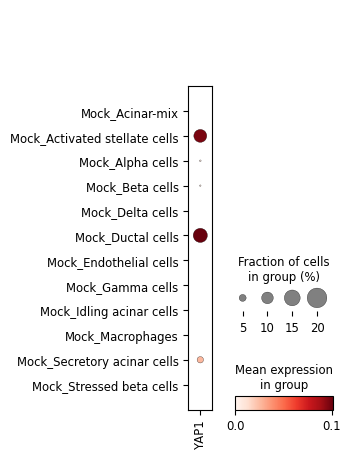

In [92]:
sc.pl.dotplot(Mock,var_names='YAP1',groupby=['status','predicted_labels'],save='YAP1_Mock_vertical.png')

In [97]:
subset_adata.obs['infection_status'].value_counts()

infection_status
Mock           26838
NonInfected     9017
Infected        5116
Name: count, dtype: int64

In [98]:
subset_adata_mock_infected = subset_adata[subset_adata.obs['infection_status'].isin(['Mock','Infected'])].copy()

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [99]:
subset_adata_mock_infected

AnnData object with n_obs × n_vars = 31954 × 36613
    obs: 'cell_id', 'status', 'sample', 'n_counts', 'n_genes', 'mito_fraction', 'predicted_labels', 'conf_score', '_scvi_batch', '_scvi_labels', 'cell_infected_status', 'polyprotein_expr', 'YAP1_classification', 'YAP1_status', 'infection_status', 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'umap', 'status_colors', 'predicted_labels_colors', 'sample_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/tmp/ipykernel_1441810/486109214.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  filtered_adata.obs['gene_expression'] = filtered_adata[:, gene_name].X.toarray().flatten()
/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


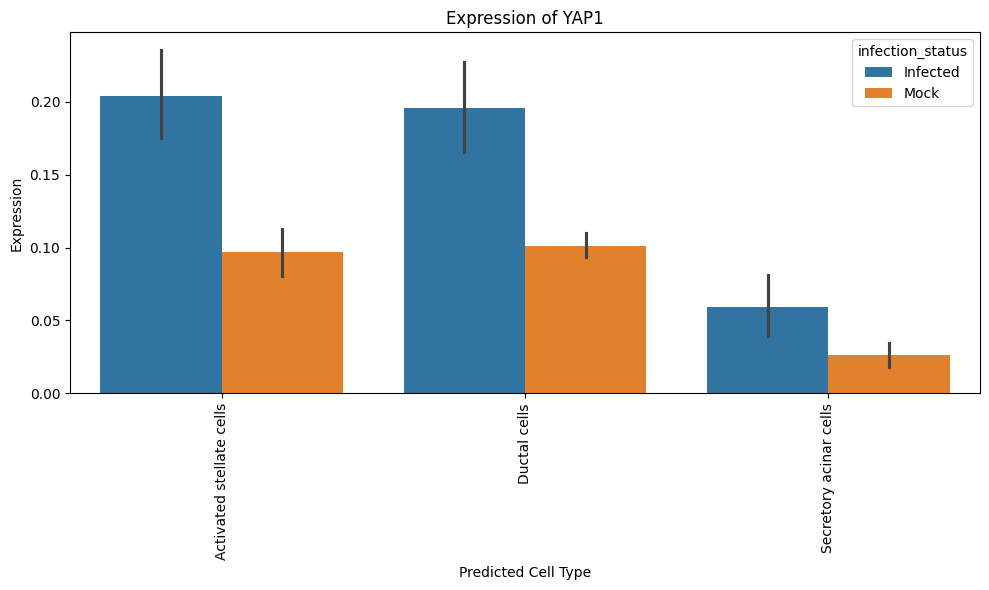

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_labels = [
  'Activated stellate cells',  'Ductal cells', 
       'Secretory acinar cells'
]

filtered_adata = subset_adata_mock_infected[subset_adata_mock_infected.obs['predicted_labels'].isin(selected_labels)]

# Create a new column with the gene expression values for plotting
gene_name = 'YAP1'  # replace with the actual gene name
filtered_adata.obs['gene_expression'] = filtered_adata[:, gene_name].X.toarray().flatten()

# Create 'infection_status' by extracting the part before the underscore in 'cell_infected_status'
filtered_adata.obs['infection_status'] = filtered_adata.obs['cell_infected_status'].str.split('_').str[0]

# Create the barplot (not stacked)
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_adata.obs, x='predicted_labels', y='gene_expression', hue='infection_status', dodge=True)
plt.title(f'Expression of {gene_name}')
plt.xlabel('Predicted Cell Type')
plt.ylabel('Expression')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Adjust layout
plt.tight_layout()
plt.savefig("./figures/YAP1_expression.png", dpi=600)

# Show plot
plt.show()


In [58]:
# Parse YAP1_classification correctly
subset_adata.obs['YAP1_status'] = subset_adata.obs['YAP1_classification'].str.extract(r'(YAP1_[a-z]+)')[0]
subset_adata.obs['infection_status'] = subset_adata.obs['YAP1_classification'].str.split('_').str[2]
subset_adata.obs['cell_type'] = subset_adata.obs['YAP1_classification'].str.split('_', n=3).str[3]


In [61]:
cvb_stellate = subset_adata[subset_adata.obs['YAP1_classification'].isin([ 'YAP1_high_Infected_Activated stellate cells',  'YAP1_low_Infected_Activated stellate cells'])].copy()

In [62]:
# Check for duplicate indices
duplicates = cvb_stellate.obs.index.duplicated().sum()
print(f"Number of duplicate indices: {duplicates}")


Number of duplicate indices: 4


In [63]:
# Reset the index and create a unique index
cvb_stellate.obs.reset_index(drop=True, inplace=True)


In [64]:
# set STIM as class 0, CTRL as class 1, to make categorical
cvb_stellate.obs['YAP1_classification'] = pd.Categorical(cvb_stellate.obs['YAP1_classification'], categories=[ 'YAP1_high_Infected_Activated stellate cells',  'YAP1_low_Infected_Activated stellate cells'], ordered=True)
indices = cvb_stellate.obs.sort_values(['predicted_labels', 'YAP1_classification']).index
cvb_stellate = cvb_stellate[indices,:]

In [65]:
np.unique(cvb_stellate.obs['YAP1_classification'])

array(['YAP1_high_Infected_Activated stellate cells',
       'YAP1_low_Infected_Activated stellate cells'], dtype=object)

In [67]:
np.unique(cvb_stellate.obs['infection_status'])

array(['Infected'], dtype=object)

In [68]:
import time
import gseapy as gp
t1 = time.time()
res = gp.gsea(data=cvb_stellate.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=cvb_stellate.obs.YAP1_classification,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


36.348854780197144


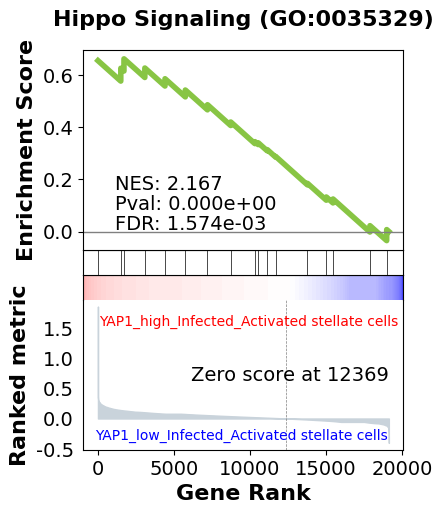

In [69]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Hippo Signaling (GO:0035329)')

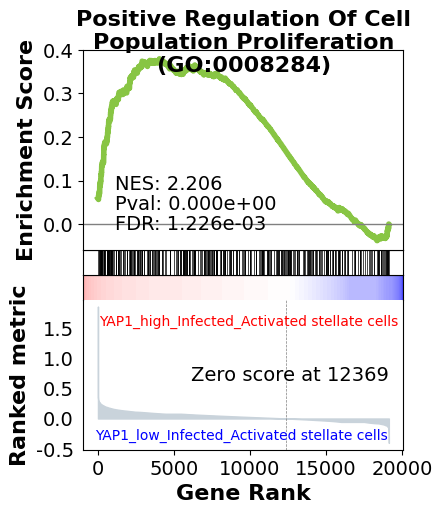

In [70]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Positive Regulation Of Cell Population Proliferation (GO:0008284)')

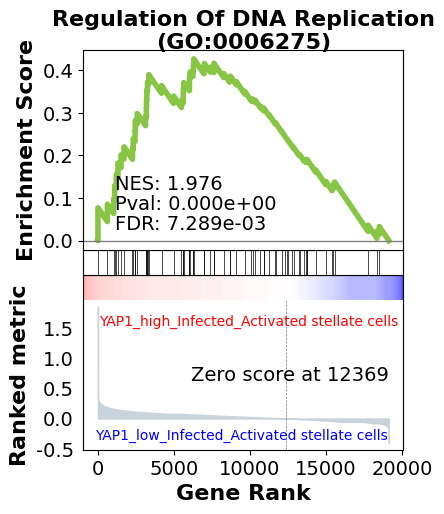

In [71]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Regulation Of DNA Replication (GO:0006275)')

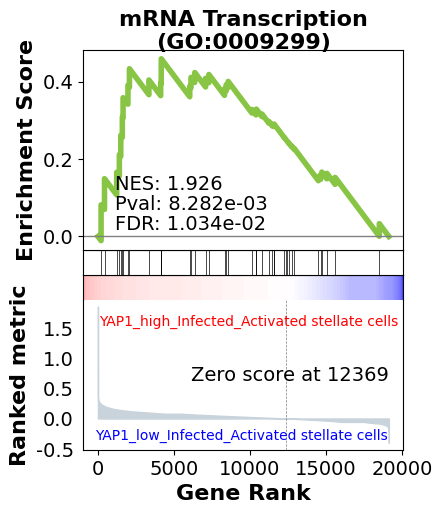

In [72]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='mRNA Transcription (GO:0009299)')

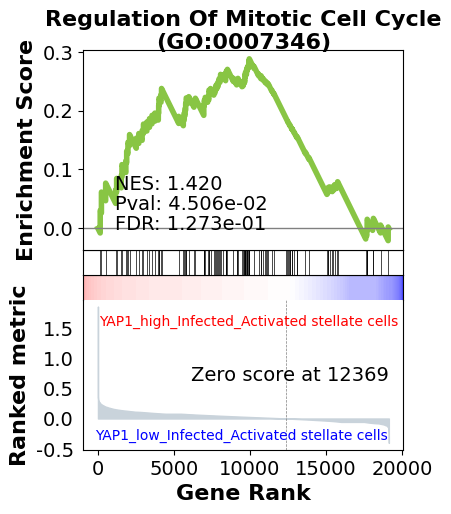

In [73]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Regulation Of Mitotic Cell Cycle (GO:0007346)')

In [77]:
cvb_ductal = subset_adata[subset_adata.obs['YAP1_classification'].isin([ 'YAP1_high_Infected_Ductal cells',  'YAP1_low_Infected_Ductal cells'])].copy()

In [78]:
cvb_ductal

AnnData object with n_obs × n_vars = 397 × 36613
    obs: 'cell_id', 'status', 'sample', 'n_counts', 'n_genes', 'mito_fraction', 'predicted_labels', 'conf_score', '_scvi_batch', '_scvi_labels', 'cell_infected_status', 'polyprotein_expr', 'YAP1_classification', 'YAP1_status', 'infection_status', 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'umap', 'status_colors', 'predicted_labels_colors', 'sample_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [80]:
import time
import gseapy as gp
t1 = time.time()
res = gp.gsea(data=cvb_ductal.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=cvb_ductal.obs.YAP1_classification,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

/software/cellgen/team361/am74/envs/scanpy/lib/python3.10/site-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


29.999440908432007


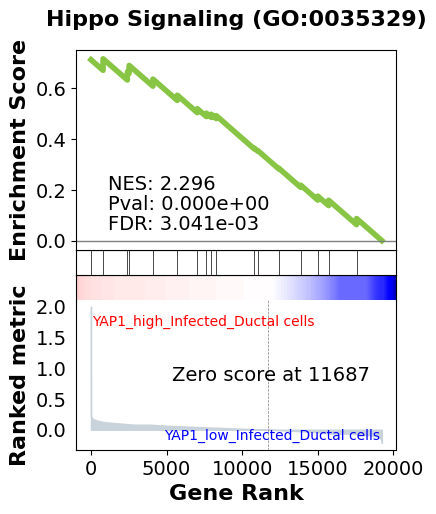

In [81]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Hippo Signaling (GO:0035329)')

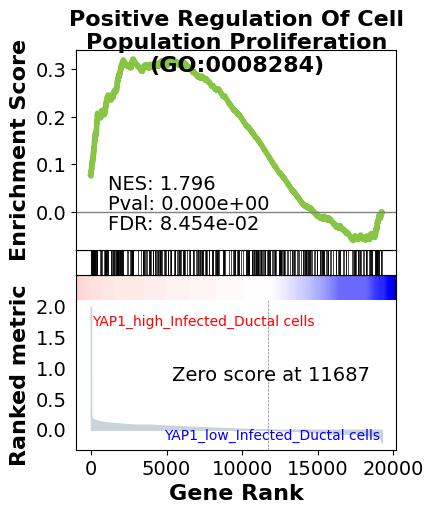

In [82]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Positive Regulation Of Cell Population Proliferation (GO:0008284)')

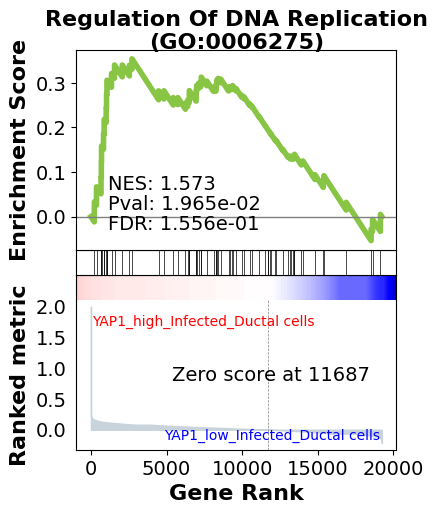

In [83]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Regulation Of DNA Replication (GO:0006275)')

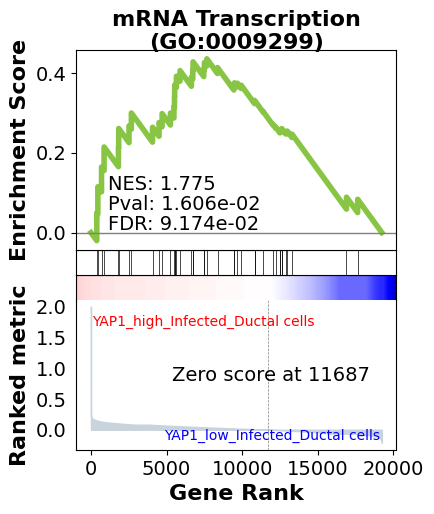

In [84]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='mRNA Transcription (GO:0009299)')

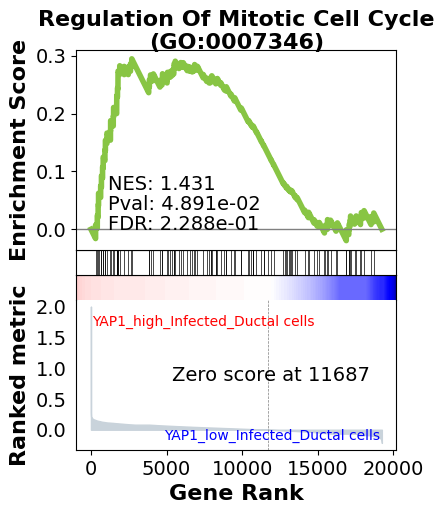

In [85]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms='Regulation Of Mitotic Cell Cycle (GO:0007346)')